In [1]:
%load_ext autoreload
%autoreload 2

import gc
from datetime import datetime
from matplotlib import pyplot as plt

# from X_generator import *
from create_dataset_utils import *

In [2]:
clients_devices = pd.read_csv('../clients_devices.csv')
clients_devices = clients_devices[clients_devices.status == 'active']
clients_devices

,client,device,sr,model_version,account_id,device_id,v1_model_name,v3_model_name,status
0,Kcdda,1,0.004000,1,5ea84272173b3d0011b3621f,5ea9c267173b3d0011b36ee2,06-24-Kcdda-1-v1-048-f9076f00,06-24-Kcdda-1-v3-001-ec8de1a5,active
2,SickKids,1,0.010000,2,5e99a9e22386af0010ba7404,5ec54b3d4d4a86001106cf08,sagemaker-ecr-2020-06-28-15-01-51-517,sagemaker-ecr-2020-06-28-15-37-20-869,active
3,WMU,1,0.000020,1,5ec7da694d4a86001106da83,5ec7db437f736700114636a9,06-24-WMU-1-v1-014-07b2bf1c,06-24-WMU-1-v3-036-85e12877,active
8,Peachtree,1,0.010000,5,5e85a5cc008b0c0010ed90da,5f07251af684220011267b3f,09-16-Peachtree-1-v1-004-55d9e3c8,09-16-Peachtree-1-v3-032-a01d1236,active
9,Eugene,1,0.000500,1,5ed4e7c5403dc20018b47e6c,5f19fcb75a19bc0011aa61dc,07-29-Eugene-1-v1-043-a3dcd90a,07-29-Eugene-1-v3-050-0dd4dee8,active
10,Eugene,2,0.000500,1,5ed4e7c5403dc20018b47e6c,5f1b1cbd5a19bc0011aa66ff,07-29-Eugene-2-v1-036-a7983719,07-29-Eugene-2-v3-021-fa6da1bb,active
11,Eugene,Firewall,0.000500,1,5ed4e7c5403dc20018b47e6c,5f19f5f45a19bc0011aa618e,07-29-Eugene-Firewall-v1-011-d016f378,07-29-Eugene-Firewall-v3-015-5ac69009,active
12,DouglasCounty,1,0.000122,1,5f15d4502997970011989705,5f1eee725a19bc0011aa73dd,08-05-DouglasCounty-1-v1-025-b6d4f962,08-05-DouglasCounty-1-v3-006-1d38bf39,active
14,Restorepoint,1,0.100000,2,5f53901a4e0ffa001a08ba2e,5f53971d4e0ffa001a08ba89,sagemaker-ecr-2020-09-17-10-28-14-518,09-16-Restorepoint-1-v3-006-73dcd68f,active


In [3]:
bucket='rsrch-cynamics-datasets'

devices = [
    ('Sioux', 1, 1/1000,1)
]
client, device, sr, model_version = devices[0]
print(f'Working on {client} device={device} model={model_version}')

Working on Sioux device=1 model=1


In [8]:
days_by_type = {
'train': ["2023-02-01"],
   # first 3 days
'val': [],
    #last 2 days
    #aviv: remove comment when adding test days
    #for sanity check later
    'test':  []
}

## Read training, extract 'tracked_values'

In [9]:
try:
    s3_filepath = f'clients/{client}/sr={sr}/device={device}/version=3/model={model_version}/type=train/tracked_values.json'
    tracked_values = eval(boto3.resource('s3').Object(bucket, s3_filepath).get()['Body'].read())
    print(f'Tracked values loaded successfully from {s3_filepath}')
except:
    training_df_list = {}
    for day in days_by_type['train']:
        print(f'Loading {day} from S3 ', end='...')
        sampled_df = pd.read_csv(f's3://{bucket}/clients/{client}/sr={sr}/device={device}/sampled/{day}.csv.gz')
        print('Done!', sampled_df.shape)

#         if day == '2020-07-27':
#             fp_start, fp_end = 1595856340, 1595882714
#             sampled_df = sampled_df[(sampled_df.time_window >= fp_start-60) & (sampled_df.time_window <= fp_end+60)]
        mean_packets_count = sampled_df.groupby('time_window').sum()['flowPackets'].mean()
        print(sampled_df.shape, mean_packets_count)
        training_df_list[day] = sampled_df

    print('Extracting tracked_values...', end='')
    tracked_values = get_tracked_values(pd.concat(training_df_list.values()), 
                                        f'clients/{client}/sr={sr}/device={device}/version=3/model={model_version}/type=train/',
                                        connections_tracking_size=10_000)
    print('Done!')
    del training_df_list

Tracked values loaded successfully from clients/Sioux/sr=0.001/device=1/version=3/model=1/type=train/tracked_values.json


## Read each day, extract X & y for v1 and v2

In [10]:
print(f'Working on {client} device={device}')
s3_bucket = boto3.resource('s3').Bucket('rsrch-cynamics-datasets')

Working on Sioux device=1


----------------
Working on train
----------------
Loading 2023-02-01 from S3 ...Done! (137992, 8)
Shape after sampling: (137992, 8)
Mean packet count: 78.2589048378522
Generating X1 for 2023-02-01...Saving...

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


(5653, 20, 18) Done!
Generating X3 for 2023-02-01...Saving...(5653, 20, 594) Done!
2023-02-01 Counter({False: 5653})


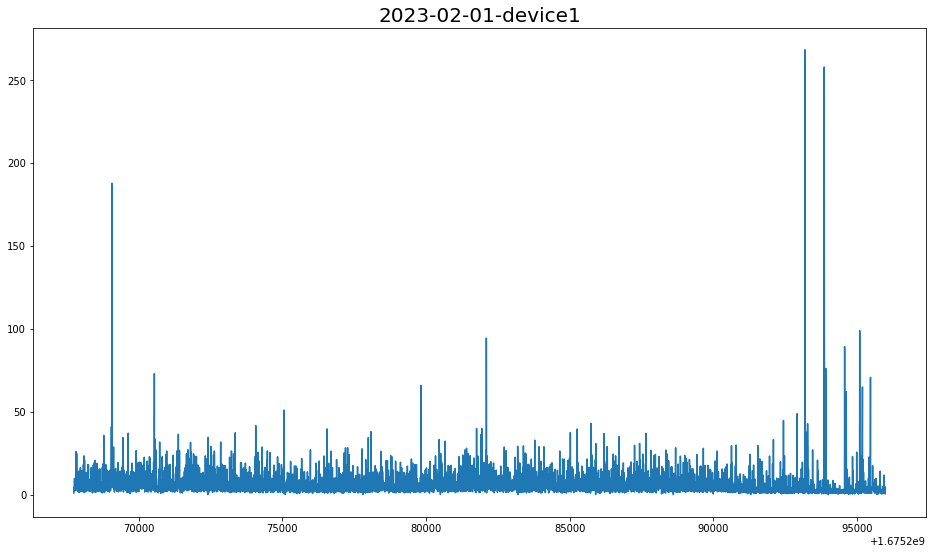

----------------
Working on val
----------------
----------------
Working on test
----------------


In [11]:


for dataset_type, days in days_by_type.items():
#     if dataset_type != 'test':
#         continue
    print(f'----------------\nWorking on {dataset_type}\n----------------')
    for day in days:
        print(f'Loading {day} from S3 ', end='...')
        sampled_df = pd.read_csv(f's3://{bucket}/clients/{client}/sr={sr}/device={device}/sampled/{day}.csv.gz')
        print('Done!', sampled_df.shape)

        create_X_v1_v3(sampled_df, day, client, device, sr, model_version, dataset_type)